# Relighting a Real Bedroom Image

In [1]:
import os, sys, inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models.models import create_model

from importlib import reload
from pbw_utils import zdataset, show, labwidget, paintwidget, renormalize, nethook, imgviz, pbar
from PIL import Image
import numpy as np
import torch

In [3]:
#load model
cmd = ('--name alternate_train_lamp '
       '--netG modulated --no_instance ' 
       '--input_nc 3 ' 
       '--label_nc 0 ' 
       '--dataroot /datasets/agata_light_all/ ' 
       '--which_epoch 600 ').split()

opt = TestOptions().parse(save=False, cmd=cmd)
model = create_model(opt)

------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: /datasets/agata_light_all/
debug: False
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
frac_neg_one: False
frac_one: False
generated: False
gpu_ids: [0]
how_many: 50
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_local_enhancers: 1
n_stylechannels: 1
name: alternate_train_lamp
nef: 16
netG: modulated
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: True
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: False
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: Fa


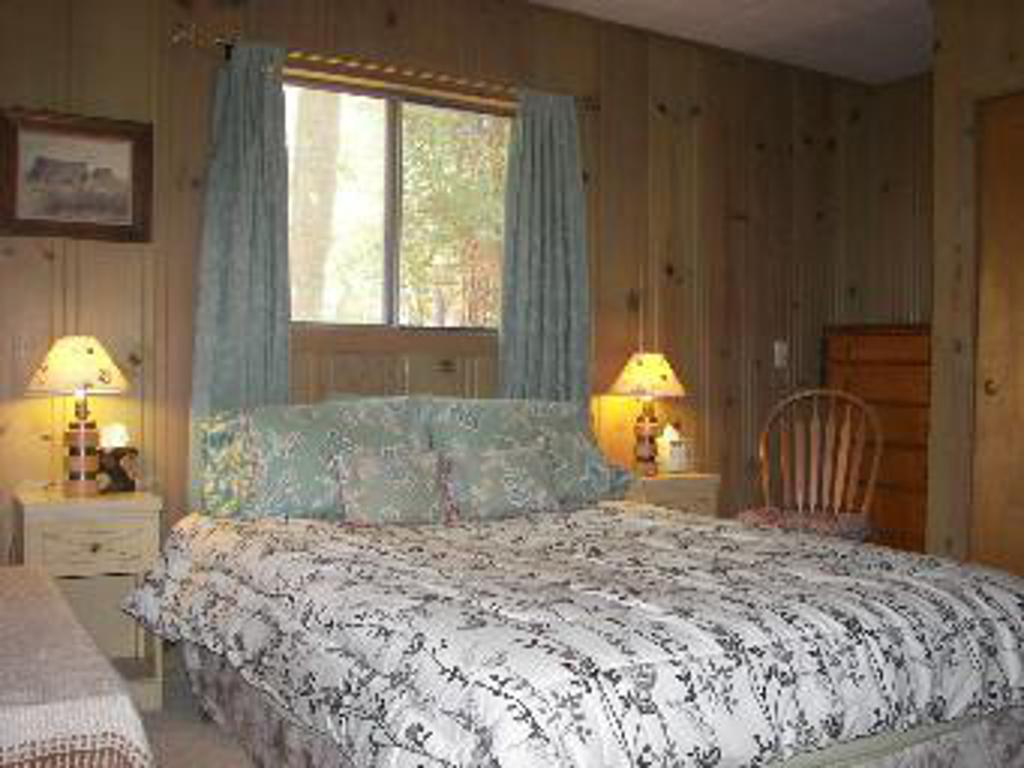

In [4]:
#load image
import torchvision.transforms as transforms
from data.base_dataset import __scale_width
transforms = transforms.Compose([transforms.Lambda(lambda img: __scale_width(img, opt.loadSize)), 
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#img_path = 'datasets/lsun_bedrooms/test_A/00000089629ce3ba87bae003073896ba01988dee.webp'
#img_path = 'datasets/bedrooms/test_A/golden_bedroom.png'
img_path = 'datasets/bedrooms/test_A/window_lamp_3.jpeg'
#img_path = 'datasets/bedrooms/test_A/wa309_1.jpg'
image = Image.open(img_path)
show(image)
baseline = transforms(image.convert('RGB'))



In [5]:
#widget for controlling lamps and windows

reload(labwidget)
lamp = labwidget.Range()
window = labwidget.Range()
im = labwidget.Image()
lc = labwidget.ColorPicker('#ffffff', desc='lamp light color: ')
wc = labwidget.ColorPicker('#ffffff', desc='window light color: ')

# #num.value = image_number
# lay.value = 'layer8'
# uni.value = 397

#show([['lamp intensity', lamp, '', 'window intensity', window, im]])
show([['lamp intensity', lamp, lc, 'window intensity', window, wc, im]])
#show([['lamp intensity', lamp, 'window intensity', window, window_color, im]])

#change to forward pass of pix2pix
#self.units = [265, 397] [lamp, window]
#amount is a list 
def get_lit_scene(image, frac):
    generated = model.inference(image.unsqueeze(0), None, None, amount=frac)
    return generated

#baseline = get_lit_scene(image, [-1.0, -1.0], lay.value, uni.value)
im.render(renormalize.as_image(baseline))

def readcolor(value):
    try:
        floatcolor = [float(int(value[i:i+2], 16))/255.0  for i in [1,3,5]]
        color = torch.tensor(floatcolor).float()
        #print('color', color)
        if len(color) == 3:
            return color
    except:
        pass
    return torch.tensor([1.0, 1.0, 1.0]).float()

def newimage():
    def norm_value(vals): 
        return np.array([(float(val) * 2 - 100) / 100.0 for val in vals])
    
    #frac = norm_value([lamp.value, window.value])
    lit_lamp = get_lit_scene(baseline, norm_value([lamp.value, 50])).cpu()
    lit_window = get_lit_scene(baseline, norm_value([50, window.value])).cpu()
    
    lamp_light = lit_lamp - baseline
    window_light = lit_window - baseline
    
    window_color = readcolor(wc.value)[:,None,None]
    lamp_color = readcolor(lc.value)[:,None,None]
    
    colored = baseline + (lamp_light * lamp_color) + (window_light * window_color)
    im.render(renormalize.as_image(colored[0]))

lamp.on('value', newimage)
window.on('value', newimage)
#lamp_color.on('value', newimage)
wc.on('value', newimage)
lc.on('value', newimage)
None

In [8]:
#one channel

#widget for controlling lamps and windows

reload(labwidget)
lamp = labwidget.Range()
im = labwidget.Image()
lc = labwidget.ColorPicker('#ffffff', desc='lamp light color: ')

# #num.value = image_number
# lay.value = 'layer8'
# uni.value = 397

#show([['lamp intensity', lamp, '', 'window intensity', window, im]])
show([['lamp intensity', lamp, lc, im]])
#show([['lamp intensity', lamp, 'window intensity', window, window_color, im]])

#change to forward pass of pix2pix
#self.units = [265, 397] [lamp, window]
#amount is a list 
def get_lit_scene(image, frac):
    generated = model.inference(image.unsqueeze(0), None, None, amount=frac)
    return generated

#baseline = get_lit_scene(image, [-1.0, -1.0], lay.value, uni.value)
im.render(renormalize.as_image(baseline))

def readcolor(value):
    try:
        floatcolor = [float(int(value[i:i+2], 16))/255.0  for i in [1,3,5]]
        color = torch.tensor(floatcolor).float()
        #print('color', color)
        if len(color) == 3:
            return color
    except:
        pass
    return torch.tensor([1.0, 1.0, 1.0]).float()

def newimage():
    def norm_value(vals): 
        return np.array([(float(val) * 2 - 100) / 100.0 for val in vals])
    
    #frac = norm_value([lamp.value, window.value])
    lit_lamp = get_lit_scene(baseline, norm_value([lamp.value])).cpu()
    
    lamp_light = lit_lamp - baseline
 
    lamp_color = readcolor(lc.value)[:,None,None]
    
    colored = baseline + (lamp_light * lamp_color)
    im.render(renormalize.as_image(colored[0]))

lamp.on('value', newimage)
lc.on('value', newimage)
None